In [88]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import tinycudann as tcnn

In [93]:
model8 = torch.load('../logs/sh/legoF8_planetv0.001/model.pth')
F8 = model8['model']['features']
model248 = torch.load('../logs/sh/legoF2_4_8_planetv0.001/model.pth')
F248 = model248['model']['features']
print(f'F8 shape is {F8.shape}, F248 shape is {F248.shape}')

F8 shape is torch.Size([28, 8, 8, 8, 8, 8]), F248 shape is torch.Size([28, 8, 8, 8, 8, 8])


In [94]:
direction_encoder = tcnn.Encoding(
            n_input_dims=3,
            encoding_config={
                "otype": "SphericalHarmonics",
                "degree": 3,
            },
        )
sh_mult = direction_encoder(torch.zeros(1,3).cuda()).cpu().detach().numpy()  # [1, 9]
print(sh_mult.shape)





(1, 9)


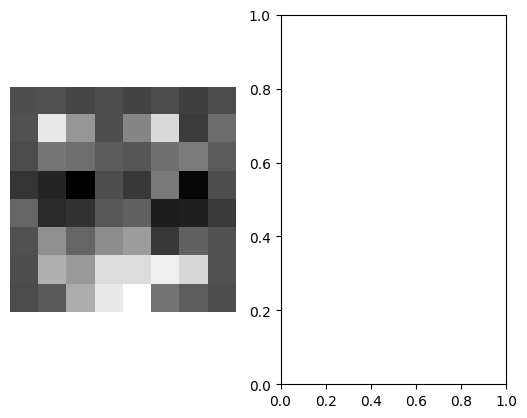

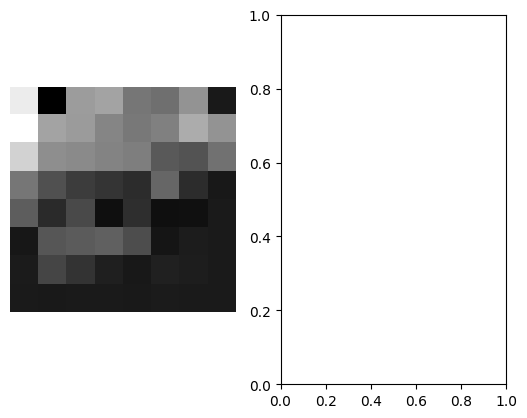

In [95]:
def visualize_slice(F, sh_mult, coords):
    # If coords are the ones we want to keep, construct the ones we want to not keep
    assert len(coords) == 2
    assert not (0 in coords)
    uncoords = [0,1,2,3,4,5]
    uncoords = [i for i in uncoords if not (i in coords)]
    # slice F according to the coordinates
    Fslice = F.cpu().numpy()
    Fslice = np.take(Fslice, 0, axis=uncoords[3])
    Fslice = np.take(Fslice, 0, axis=uncoords[2])
    Fslice = np.take(Fslice, 0, axis=uncoords[1])
    # visualize sigma (last entry) and the zero degree harmonics (reshape into 3 by 9, then take first set of 3 as rgb)
    sigma = Fslice[-1,:,:]
    # rgb = Fslice[0:-1].reshape(3, -1, 6, 6)
    # # rgb = np.sum(rgb * sh_mult[:,:,None,None], axis=1)
    # rgb = rgb * sh_mult[:,:,None,None]
    # rgb = rgb[:,0,:,:]
    # rgb = torch.sigmoid(torch.from_numpy(rgb)).numpy()
    # rgb = rgb.transpose(1,2,0)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(sigma, cmap='gray')
    ax[0].set_axis_off()
    # ax[1].imshow(rgb)
    # ax[1].set_axis_off()
    plt.show()
    


visualize_slice(F8, sh_mult, coords=[1,2])
visualize_slice(F248, sh_mult, coords=[1,2])
# visualize_slice(F, sh_mult, coords=[1,3])
# visualize_slice(F, sh_mult, coords=[1,4])
# visualize_slice(F, sh_mult, coords=[1,5])
# visualize_slice(F, sh_mult, coords=[2,3])
# visualize_slice(F, sh_mult, coords=[2,4])
# visualize_slice(F, sh_mult, coords=[2,5])
# visualize_slice(F, sh_mult, coords=[3,4])
# visualize_slice(F, sh_mult, coords=[3,5])
# visualize_slice(F, sh_mult, coords=[4,5])

## Visualize ray sampling


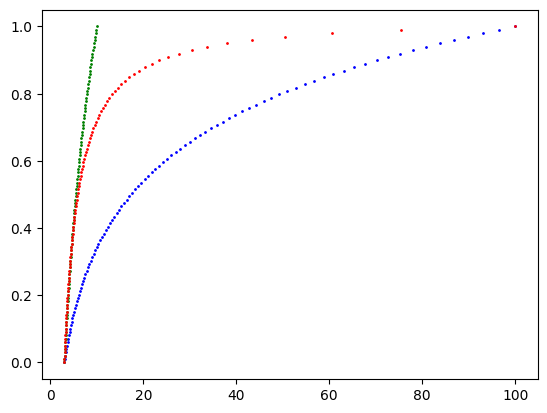

In [4]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
def genspace(start, stop, num, fn, inv_fn):
    """A generalization of linspace(), geomspace(), and NeRF's "lindisp".
    Behaves like jnp.linspace(), except it allows an optional function that
    "curves" the values to make the spacing between samples not linear.
    If no `fn` value is specified, genspace() is equivalent to jnp.linspace().
    If fn=jnp.log, genspace() is equivalent to jnp.geomspace().
    If fn=jnp.reciprocal, genspace() is equivalent to NeRF's "lindisp".
    Args:
    start: float tensor. The starting value of each sequence.
    stop: float tensor. The end value of each sequence.
    num: int. The number of samples to generate for each sequence.
    fn: function. A jnp function handle used to curve `start`, `stop`, and the
      intermediate samples.
    Returns:
    A tensor of length `num` spanning [`start`, `stop`], according to `fn`.
    """
    # Linspace between the curved start and stop values.
    t = torch.linspace(0., 1., num)
    s = fn(start) * (1. - t) + fn(stop) * t

    # Apply `inv_fn` and clamp to the range of valid values.
    return torch.clip(inv_fn(s), torch.minimum(start, stop), torch.maximum(start, stop))

num = 100
gamma = torch.Tensor([1.5])
y = torch.linspace(0., 1., num)
x = genspace(torch.Tensor([3]), torch.Tensor([100]), num, torch.log, torch.exp)
plt.scatter(x, y, c='blue', s=1)
# print(f'when my range is 2 to 10, the first delta is {y[1] - y[0]} and the second is {y[2]-y[1]}, with ratio {(y[2]-y[1]) / (y[1] - y[0])}')

y = torch.linspace(0., 1., num)
x = genspace(torch.Tensor([3]), torch.Tensor([10]), num, lambda a: torch.log(a)/torch.log(gamma), lambda a: gamma ** a)
plt.scatter(x, y, c='green', s=1)
# print(f'when my range is 2 to 6, the first delta is {y[1] - y[0]} and the second is {y[2]-y[1]}, with ratio {(y[2]-y[1]) / (y[1] - y[0])}')

y = torch.linspace(0., 1., num)
x = genspace(torch.Tensor([3]), torch.Tensor([100]), num, torch.reciprocal, torch.reciprocal)
plt.scatter(x, y, c='red', s=1)

# plt.xlim(3, 10)

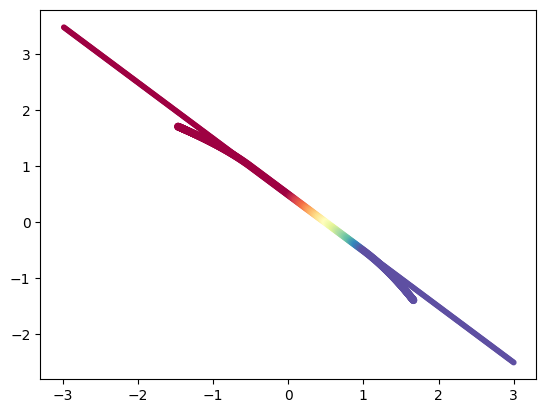

In [32]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def contract(pts):
    # pts should have shape [n_samples, 2]
    norms = torch.linalg.vector_norm(pts, ord=np.inf, dim=-1, keepdim=True).expand(-1, 2)  # [n_rays, n_samples, 3]
    norm_mask = norms > 1
    pts[norm_mask] = (2.0 - 1.0 / norms[norm_mask]) * pts[norm_mask] / norms[norm_mask]
    return pts

def make_line(m, b):
    x = torch.linspace(-3, 3, 400)
    y = m*x + b
    pts = torch.zeros(400, 2)
    pts[:,0] = x
    pts[:,1] = y
    return pts

pts = make_line(-1, 0.5)
idx = torch.linspace(-3, 3, 400)
cmap = matplotlib.cm.get_cmap('Spectral')
plt.scatter(pts[:,0], pts[:,1], c=cmap(idx), s=10)
contracted = contract(pts)
plt.scatter(contracted[:,0], contracted[:,1], c=cmap(idx), s=20)

### Visualizing how our interpolation/model works, to debug the stripes/grid artifacts

aside: is the flickering over time just another instance of this artifact?

In [4]:
import torch
from plenoxels.models.utils import grid_sample_wrapper
import numpy as np
import plotly.graph_objects as go
# Let's make a basic version of our model, that uses density only
# reso = 2
# rank=1
# # init = 0.8**(1.0/(rank*3))  # 0.99 -> 0.74
# init = 0.1
# # print(f'init is {init}')
# xy = torch.ones(1, rank, reso, reso) * init
# xz = torch.ones(1, rank, reso, reso) * init
# yz = torch.ones(1, rank, reso, reso) * init

# # xz[0, :, 3, 5] = 1
# # yz[0,:,3,5] = 1
# xz[0,:,0,0] = 10
# yz[0,:,0,0] = 10

weights = torch.load('/home/sfk/plenoxels/logs/salmonvideo/multiscale64to512.150_rank4_proposal128.128_reg30k_isg30k_ist30k_lr0.01_timesmooth1_planetv0.001_scale0.6xyshift2z/model.pth')
rank = 1
# Proposal density
# xy = weights["model"]["density_field.grids.0"].to('cpu')
# xz = weights["model"]["density_field.grids.1"].to('cpu')
# yz = weights["model"]["density_field.grids.2"].to('cpu')

# Model density
xy = weights["model"]["grids.1.0"][:, -1:, ...].to('cpu')
xz = weights["model"]["grids.1.1"][:, -1:, ...].to('cpu')
yz = weights["model"]["grids.1.3"][:, -1:, ...].to('cpu')
print(xy.shape)
print(xz.shape)
print(yz.shape)

n = 128
x, y, z = np.mgrid[-1:1:n*1j, -1:1:30j, -1:1:30j]
x = torch.from_numpy(x).flatten().float()
y = torch.from_numpy(y).flatten().float()
z = torch.from_numpy(z).flatten().float()
xycoords = torch.stack([x, y], dim=-1)  # [dim^3, 2]
xzcoords = torch.stack([x, z], dim=-1)  # [dim^3, 2]
yzcoords = torch.stack([y, z], dim=-1)  # [dim^3, 2]
xyinterp = grid_sample_wrapper(xy, xycoords) # [dim^3, rank]
xzinterp = grid_sample_wrapper(xz, xzcoords) # [dim^3, rank]
yzinterp = grid_sample_wrapper(yz, yzcoords) # [dim^3, rank]
if rank > 1:
    result = torch.mean(xyinterp * xzinterp * yzinterp, dim=-1)
else: 
    result = xyinterp * xzinterp * yzinterp


fig = go.Figure(data=go.Volume(
    x=x,
    y=y,
    z=z,
    value=result,
    isomin=-0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=21, # needs to be a large number for good volume rendering
    ))
fig.show()

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([115200])
torch.Size([])


ValueError: 
    Invalid value of type 'torch.Tensor' received for the 'value' property of volume
        Received value: tensor(-0.0099)

    The 'value' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [6]:
import torch

weights = torch.load('/home/sfk/plenoxels/logs/salmonvideo/multiscale64to512.150_rank4_proposal128.128_reg30k_isg30k_ist30k_lr0.01_timesmooth1_planetv0.001_scale0.6xyshift2z/model.pth')
rank = 1
# Proposal density
# xy = weights["model"]["density_field.grids.0"].to('cpu')
# xz = weights["model"]["density_field.grids.1"].to('cpu')
# yz = weights["model"]["density_field.grids.2"].to('cpu')

# Model density
xy = weights["model"]["grids.3.0"][:, -1:, ...].to('cpu')
xz = weights["model"]["grids.3.1"][:, -1:, ...].to('cpu')
yz = weights["model"]["grids.3.3"][:, -1:, ...].to('cpu')
print(xy.shape)
print(xz.shape)
print(yz.shape)

torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])


In [14]:
import torch
from plenoxels.models.utils import grid_sample_wrapper
import numpy as np
import plotly.graph_objects as go
# Let's make a basic version of our model, that uses density only
reso = 10
rank=1
# init = 0.8**(1.0/(rank*3))  # 0.99 -> 0.74
init = 0.0
# print(f'init is {init}')
xy = torch.ones(1, rank, reso, reso) * init
xz = torch.ones(1, rank, reso, reso) * init
yz = torch.ones(1, rank, reso, reso) * init

# want to turn on point [3, 5, 9]
xz[0,:,3,3] = 1
yz[0,:,3,3] = 1
xy[0,:,3,3] = 1
# xz[0,:,0,0] = 10
# yz[0,:,0,0] = 10

# weights = torch.load('/home/sfk/plenoxels/logs/salmonvideo/multiscale64to512.150_rank4_proposal128.128_reg30k_isg30k_ist30k_lr0.01_timesmooth1_planetv0.001_scale0.6xyshift2z/model.pth')
# rank = 1
# Proposal density
# xy = weights["model"]["density_field.grids.0"].to('cpu')
# xz = weights["model"]["density_field.grids.1"].to('cpu')
# yz = weights["model"]["density_field.grids.2"].to('cpu')

# Model density
# xy = weights["model"]["grids.1.0"][:, -1:, ...].to('cpu')
# xz = weights["model"]["grids.1.1"][:, -1:, ...].to('cpu')
# yz = weights["model"]["grids.1.3"][:, -1:, ...].to('cpu')
# print(xy.shape)
# print(xz.shape)
# print(yz.shape)

n = 30
x, y, z = np.mgrid[-1:1:n*1j, -1:1:30j, -1:1:30j]
x = torch.from_numpy(x).flatten().float()
y = torch.from_numpy(y).flatten().float()
z = torch.from_numpy(z).flatten().float()
xycoords = torch.stack([x, y], dim=-1)  # [dim^3, 2]
xzcoords = torch.stack([x, z], dim=-1)  # [dim^3, 2]
yzcoords = torch.stack([y, z], dim=-1)  # [dim^3, 2]
xyinterp = grid_sample_wrapper(xy, xycoords) # [dim^3, rank]
xzinterp = grid_sample_wrapper(xz, xzcoords) # [dim^3, rank]
yzinterp = grid_sample_wrapper(yz, yzcoords) # [dim^3, rank]
if rank > 1:
    result = torch.mean(xyinterp * xzinterp * yzinterp, dim=-1)
else: 
    result = 0.333 * (xyinterp + xzinterp + yzinterp)
print(yzinterp.shape)
print(result.shape)

fig = go.Figure(data=go.Volume(
    x=x,
    y=y,
    z=z,
    value=result,
    isomin=-0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=21, # needs to be a large number for good volume rendering
    ))
fig.show()

torch.Size([27000])
torch.Size([27000])


## Visualizing importance sampling.

In [6]:
from plenoxels.datasets.video_datasets import load_llffvideo_poses, load_llffvideo_data
# Load a video
per_cam_poses, per_cam_near_fars, intrinsics, videopaths = load_llffvideo_poses(
                datadir='/home/sfk/data/3DVideo/flame_salmon_1/', downsample=4, split='test', near_scaling=1.0)
poses, imgs, timestamps, median_imgs = load_llffvideo_data(
    videopaths=videopaths, cam_poses=per_cam_poses, intrinsics=intrinsics, split='test',
    keyframes=False, keyframes_take_each=30)
# imgs is shape [300, 507, 676, 3]
# median_imgs is shape [1, 507, 676, 3]

/home/sfk/miniconda3/envs/py38torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading test data: 100%|██████████| 1/1 [00:36<00:00, 36.24s/it]


In [8]:
from plenoxels.datasets.video_datasets import load_llffvideo_poses, load_llffvideo_data
# Load the train data
per_cam_poses, per_cam_near_fars, intrinsics, videopaths = load_llffvideo_poses(
                datadir='/home/sfk/data/3DVideo/flame_salmon_1/', downsample=4, split='train', near_scaling=1.0)
poses, imgs, timestamps, median_imgs = load_llffvideo_data(
    videopaths=videopaths, cam_poses=per_cam_poses, intrinsics=intrinsics, split='train',
    keyframes=False, keyframes_take_each=30)
print(imgs.shape)  # [5400, 507, 676, 3]
print(median_imgs.shape)  # [18, 507, 676, 3]




Loading train data: 100%|██████████| 18/18 [01:38<00:00,  5.45s/it]


torch.Size([5400, 507, 676, 3])
torch.Size([18, 507, 676, 3])


In [9]:
import torch

def dynerf_isg_weight(imgs, median_imgs, gamma=2e-2):
    # imgs is [num_cameras * num_frames, h, w, 3]
    # median_imgs is [num_cameras, h, w, 3]
    num_cameras, h, w, c = median_imgs.shape
    differences = median_imgs[:, None, ...] - imgs.view(num_cameras, -1, h, w, c)  # [num_cameras, num_frames, h, w, 3]
    squarediff = torch.square_(differences)
    psidiff = squarediff.div_(squarediff + gamma**2)
    psidiff = (1./3) * torch.sum(psidiff, dim=-1)  # [num_cameras, num_frames, h, w]
    return psidiff  # valid probabilities, each in [0, 1]


def dynerf_ist_weight(imgs, num_cameras, alpha=0.1, frame_shift=25):  # DyNerf uses alpha=0.1
    N, h, w, c = imgs.shape
    frames = imgs.view(num_cameras, -1, h, w, c)  # [num_cameras, num_timesteps, h, w, 3]
    max_diff = None
    shifts = list(range(frame_shift + 1))[1:]
    for shift in shifts:
        shift_left = torch.cat([frames[:,shift:,...], torch.zeros(num_cameras, shift, h, w, c)], dim=1)
        shift_right = torch.cat([torch.zeros(num_cameras, shift, h, w, c), frames[:,:-shift,...]], dim=1)
        mymax = torch.maximum(torch.abs_(shift_left - frames), torch.abs_(shift_right - frames))
        if max_diff is None:
            max_diff = mymax
        else:
            max_diff = torch.maximum(max_diff, mymax)  # [num_timesteps, h, w, 3]
    max_diff = torch.mean(max_diff, dim=-1)  # [num_timesteps, h, w]
    max_diff = max_diff.clamp_(min=alpha)
    return max_diff

In [12]:
import time

# Precompute ISG weights
t_s = time.time()
gamma = 2e-2
isg_weights = dynerf_isg_weight(
    imgs.view(-1, intrinsics.height, intrinsics.width, imgs.shape[-1]),
    median_imgs, gamma)
# Normalize into a probability distribution, to speed up sampling
isg_weights = (isg_weights.reshape(-1) / torch.sum(isg_weights))
t_e = time.time()
print(f"Computed {isg_weights.shape[0]} ISG weights in {t_e - t_s:.2f}s.")

# Precompute IST weights
t_s = time.time()
ist_weights = dynerf_ist_weight(
    imgs.view(-1, intrinsics.height, intrinsics.width, imgs.shape[-1]),
    num_cameras=median_imgs.shape[0])
# Normalize into a probability distribution, to speed up sampling
ist_weights = (ist_weights.reshape(-1) / torch.sum(ist_weights))
t_e = time.time()
print(f"Computed {ist_weights.shape[0]} IST weights in {t_e - t_s:.2f}s.")

Computed 1850752800 ISG weights in 9.90s.
Computed 1850752800 IST weights in 463.44s.


In [13]:
torch.save(isg_weights, 'isg_weights.pt')
torch.save(ist_weights, 'ist_weights.pt')

In [14]:
reloaded_isg = torch.load('isg_weights.pt')
reloaded_ist = torch.load('ist_weights.pt')
print(reloaded_isg.shape)
print(reloaded_ist.shape)

torch.Size([1850752800])
torch.Size([1850752800])


In [2]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_weights(imgs, isgweights, istweights, how_many=2):
    fig, ax = plt.subplots(nrows=how_many, ncols=3, figsize=(12,3*how_many))
    idx = np.random.choice(len(imgs), how_many)
    print(f'looking at frames {idx}')
    for index in range(how_many):
        ax[index, 0].imshow(imgs[idx[index]])
        ax[index, 0].axis("off")
        im = ax[index, 1].imshow(isgweights[idx[index]])
        ax[index, 1].axis("off")
        plt.colorbar(im, ax=ax[index, 1], aspect=20, fraction=0.04)
        im = ax[index, 2].imshow(istweights[idx[index]])
        ax[index, 2].axis("off")
        plt.colorbar(im, ax=ax[index, 2], aspect=20, fraction=0.04)
    fig.tight_layout()
    plt.show()

looking at frames [172  47 117]


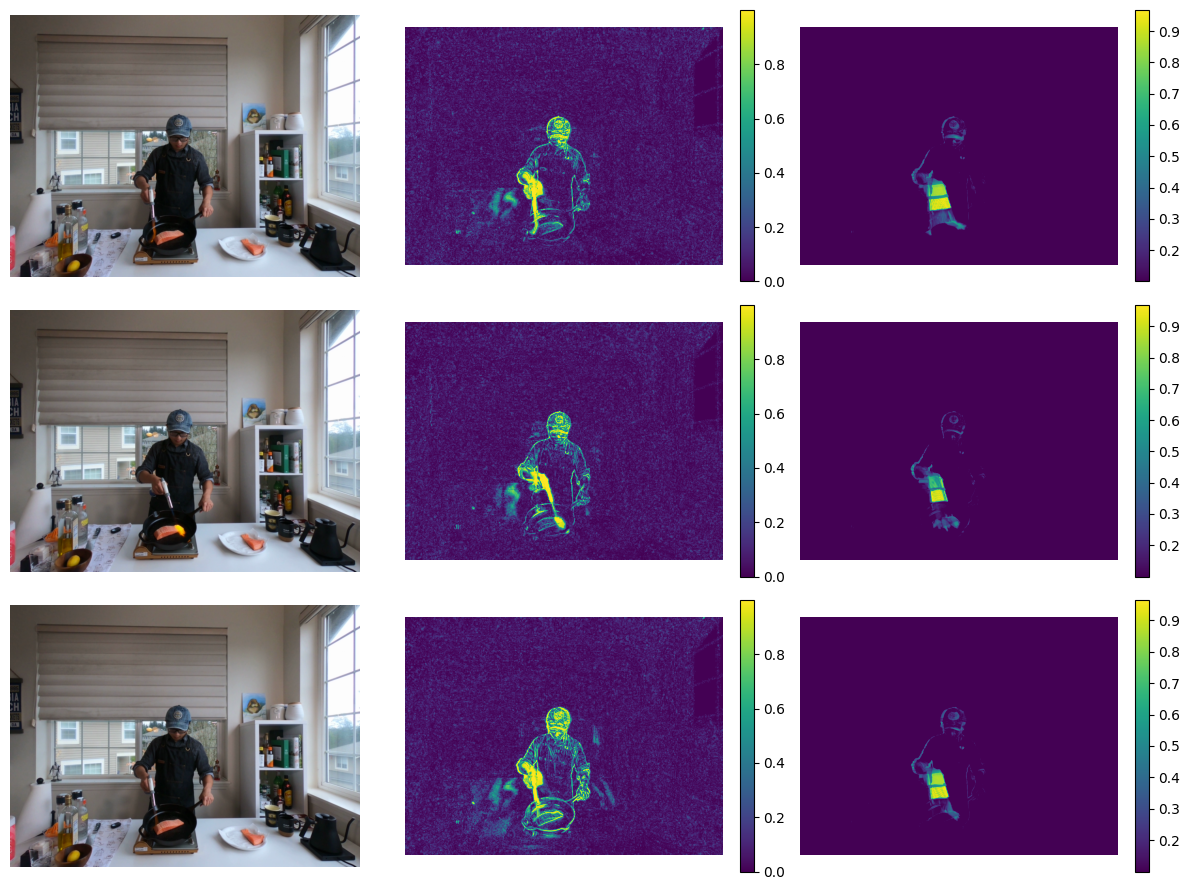

In [6]:
# Compute ISG and IST weights
isg_weights = dynerf_isg_weight(imgs, median_imgs).squeeze()  # [300, 507, 676]
ist_weights = dynerf_ist_weight(imgs, num_cameras=1, alpha=0.1, frame_shift=25).squeeze()  # [300, 507, 676]

# Visualize some frames and their weights
visualize_weights(imgs, isg_weights, ist_weights, how_many=3)